# UAS Applied Data Science for Business - 2023 SP
## Identitas Mahasiswa
| <span style="color:blue"> NIM </span> | <span style="color:blue"> Nama Panggilan </span> |
| :--- | :---: 
| 23102010093 | William |



## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set(style='darkgrid')
params = {'font.family': 'Times New Roman', 'axes.labelsize': 12, 'xtick.labelsize': 12, 
          'ytick.labelsize': 12, 'axes.labelweight': 'bold'}
plt.rcParams.update(params)

## Soal 2

### A Import dataset ke dalam format dataframe dengan nama variabel df dan tampilkan 5 baris data terakhirnya.

In [241]:
df=pd.read_csv('human_physique.csv')
df.head()

,id,dataset,weight,height,sex
0,ID0001,training,70.4,184.2,1.0
1,ID0002,training,63.8,158.7,1.0
2,ID0003,training,66.2,162.3,0.0
3,ID0004,training,66.6,155.9,0.0
4,ID0005,training,70.9,186.0,1.0


### B Buatlah rangkuman data menggunakan metode describe() dengan hanya menampilkan nilai minimal, maksimal, rata-rata, simpangan baku, lower (kuantil 2.5%), median, dan upper (kuantil 97.5%) pada kolom height dan weight sesuai dengan tipe dataset dan jenis kelaminnya.

In [242]:
df_group = df.groupby("sex")
df_group.get_group(0)[['weight','height']].describe(percentiles=[.025, .975], include=[np.number]).loc[['min','max','mean','std', '2.5%','50%','97.5%']]
# Dividing by sex and describing divided data
# Female data describe

,weight,height
min,57.700000,125.000000
max,72.400000,188.900000
mean,64.775074,144.760712
std,2.151157,13.231799
2.5%,60.900000,126.000000
50%,64.600000,142.700000
97.5%,69.300000,174.800000


In [243]:
df_group.get_group(1)[['weight','height']].describe(percentiles=[.025, .975], include=[np.number]).loc[['min','max','mean','std', '2.5%','50%','97.5%']]
## Male data describe

,weight,height
min,59.400000,125.800000
max,73.500000,190.000000
mean,67.326768,173.280342
std,2.156915,12.285607
2.5%,62.500000,144.500000
50%,67.500000,175.550000
97.5%,71.100000,189.400000


### C Lakukan features engineering untuk membuat kolom bmi.

In [244]:
df['BMI'] = df['weight']/((df['height']/100)**2)
#Membuat kolom baru 'BMI' dari pembagian weight terhadapa height dalam m^2

In [166]:
df.head()

,id,dataset,weight,height,sex,BMI
0,ID0001,training,70.4,184.2,1.0,20.748820
1,ID0002,training,63.8,158.7,1.0,25.331845
2,ID0003,training,66.2,162.3,0.0,25.131647
3,ID0004,training,66.6,155.9,0.0,27.401983
4,ID0005,training,70.9,186.0,1.0,20.493699


### D Split df menjadi train, valid, dan test sesuai dengan kolom dataset.

In [167]:
train = df.loc[df['dataset'] == 'training']
train.reset_index(drop=True, inplace=True)
#Pembuatan dataframe train dengan memilih data dengan value dataset 'training'

In [168]:
test = df.loc[df['dataset'] == 'testing']
test.reset_index(drop=True, inplace=True)
#Pembuatan dataframe test dengan memilih data dengan value dataset 'testing'

In [169]:
valid = df.loc[df['dataset'] == 'validation']
valid.reset_index(drop=True, inplace=True)
#Pembuatan dataframe valid dengan memilih data dengan value dataset 'validation'

### E Lakukan EDA terhadap height, weight, dan bmi pada train kemudian beri penjelasan singkat.

In [172]:
mean = train.groupby('sex').mean()

#membuat dataframe mean yang merupakan perhitungan mean dari weight, height, dan bmi berdasarkan pengelompokan sex

<Axes: title={'center': 'Mean EDA'}, xlabel='Sex', ylabel='Mean'>

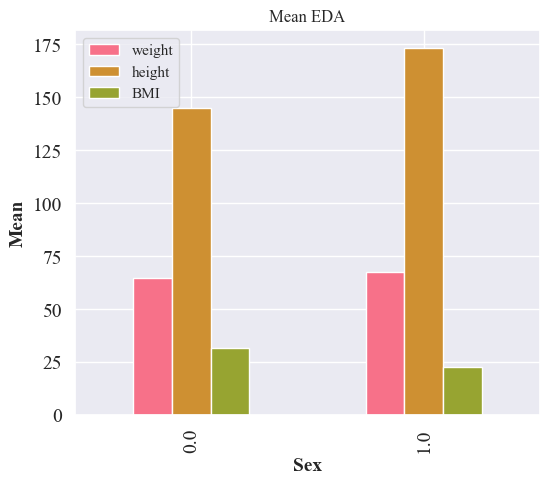

In [173]:
mean.plot(kind='bar', title='Mean EDA', ylabel='Mean',
         xlabel='Sex', figsize=(6, 5))

Bisa dilihat bahwa male memiliki height dan weight yang lebih tinggi dibandingkan dengan female. Namun female memiliki bmi yang lebih tinggi. Artinya male cendrung lebih tinggi relatif dengan berat badannya dibandingkan dengan female.

### F. Buatlah model terbaik dengan nama variabel glm menggunakan train dan H2O AutoML dengan algoritma GLM selama 1 menit. Simpan nilai threshold yang memaksimumkan nilai F1 pada valid. Beri penjelasan singkat dari model yang dihasilkan.

In [174]:
import h2o

In [180]:
h2o.init(max_mem_size = "4G")

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,16 mins 52 secs
H2O_cluster_timezone:,Asia/Jakarta
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_willi_q7afrg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.832 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [176]:
seed = 11
np.random.seed(seed)

cv_fold = train[['sex']].copy()
cv_fold.reset_index(inplace=True)
cv_fold['Random'] = np.random.random(len(train))

cv_fold.sort_values(by=["sex", 'Random'], inplace=True, ignore_index=True)

kfold = 5
cv_fold['CV_Fold'] = cv_fold.index % kfold + 1

cv_fold.sort_values(by='index', inplace=True, ignore_index=True)

train = train.assign(CV_Fold = cv_fold['CV_Fold'])

del cv_fold

#Pembuatan kolom CV_Fold untuk modeling AutoML pada H2O

In [177]:
train_frame = h2o.H2OFrame(train)
valid_frame = h2o.H2OFrame(valid)

#Mengubah dataframe menjadi H2O frame

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [178]:
start_time = pd.to_datetime('now', utc=True) + pd.Timedelta('07:00:00')
train_frame['sex'] = train_frame['sex'].asfactor()
valid_frame['sex'] = valid_frame['sex'].asfactor() 
timer(start_time, header='\nConverting DataFrame to H2O Frame')



Converting DataFrame to H2O Frame:
Start   : 2023-08-31 11:20:22 AM
Finish  : 2023-08-31 11:20:22 AM
Runtime : 00:00:00 



In [183]:
from h2o.automl import H2OAutoML

target = 'sex'
variables = ['weight','height','BMI']

runtime=60
algos=['GLM']
AML1 = H2OAutoML(max_runtime_secs=runtime,include_algos=algos,seed=seed)
AML1.train(x=variables,y=target,training_frame=train_frame,validation_frame=valid_frame,fold_column='CV_Fold')

model1 = AML1.leader

#Pembuatan model dengan h2oAutoML dengan model GLM

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%

11:27:55.701: Fold column CV_Fold will be used for cross-validation. nfolds parameter will be ignored.
11:27:55.701: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.



### G Lakukan proses yang sama seperti 2f tetapi menggunakan algoritma GBM dan simpan model yang dihasilkan dengan nama variabel gbm

In [184]:
runtime=60
algos=['GBM']
AML2 = H2OAutoML(max_runtime_secs=runtime,include_algos=algos,seed=seed)
AML2.train(x=variables,y=target,training_frame=train_frame,validation_frame=valid_frame,fold_column='CV_Fold')

model2 = AML2.leader

#Pembuatan model dengan h2oAutoML dengan model GBM

AutoML progress: |█
11:28:55.535: Fold column CV_Fold will be used for cross-validation. nfolds parameter will be ignored.
11:28:55.535: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

██████████████████████████████████████████████████████████████| (done) 100%


### H Lakukan model selection dengan kriteria nilai rata-rata estimasi AUC hasil fungsi 1a yang dijalankan sebanyak 200 kali pada valid. Agar proses model selection lebih kredibel, maka lakukan uji hipotesis dengan menggunakan fungsi scipy.stats.ttest_ind dan tingkat signifikansi 1% untuk menentukan apakah terdapat perbedaan yang signifikan estimasi AUC antara model glm dan gbm. Jelaskan hasil yang diperoleh.

In [197]:
test.drop(['sex'], axis=1, inplace=True)

In [198]:
test_frame = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [236]:
test_pred1 = model1.predict(test_frame)
test_pred2 = model2.predict(test_frame)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


### I Lakukan uji statistik power menggunakan teknik bootstrap dengan iterasi 500 kali. Jelaskan hasil yang Anda peroleh.

### J Retrain model terbaik yang diperoleh dengan menggunakan data gabungan train dan valid. Simpan model ini dengan nama variabel model kemudian prediksi kolom sex pada test menggunakan nilai threshold pada 2f atau 2g (tergantung dari model terbaik pada 2h). Save kolom id dan sex pada test dengan nama test_NIM.csv.

## Soal 3

# A

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns',None)

sns.set(style='darkgrid')
sns.set_palette('husl',8)
params = {'font.family':'Times New Roman','axes.labelsize':14,
          'xtick.labelsize':14,'ytick.labelsize':14,
          'axes.labelweight':'bold'}
plt.rcParams.update(params)

In [220]:
def read_xlsx(sheetname, filename='Northwind Database.xlsx', cols=None):
    return pd.read_excel(filename, sheet_name=sheetname, usecols=cols)

In [221]:
Products = read_xlsx('Products', cols=['ProductID','ProductName','Price'])
OrderDetails = read_xlsx('OrderDetails', cols=['OrderID','ProductID','Quantity'])
Orders = read_xlsx('Orders', cols=['OrderID', 'OrderDate','CustomerID'])
Customers = read_xlsx('Customers', cols=['CustomerID','Country'])

In [222]:
df = OrderDetails.merge(Orders, on='OrderID')
df = df.merge(Products, on='ProductID')
df = df.merge(Customers, on='CustomerID')

In [223]:
df['Total'] = df['Price']*df['Quantity']

In [224]:
df.reset_index(drop=True, inplace=True)

In [225]:
group = df.groupby(['ProductName']).agg(Total_Quantity=('Quantity','sum'),
                                 Total_Sales=('Total','sum')).sort_values(by='Total_Sales',
                                                                                    ascending=False).rename(columns={"Total_Sales": "Total Sales",
                                                                                                                            "Total_Quantity": "Total Quantity"}).head()

group

,Total Quantity,Total Sales
ProductName,,
Côte de Blaye,623,164160.50
Thüringer Rostbratwurst,746,92347.34
Raclette Courdavault,1496,82280.00
Camembert Pierrot,1577,53618.00
Tarte au sucre,1083,53391.90


# B

In [226]:
pvt = pd.pivot_table(df, values ='OrderID', index = 'CustomerID', columns = 'ProductName',
                     aggfunc='count', fill_value=0)
pvt

ProductName,Alice Mutton,Aniseed Syrup,Boston Crab Meat,Camembert Pierrot,Carnarvon Tigers,Chais,Chang,Chartreuse verte,Chef Anton's Cajun Seasoning,Chef Anton's Gumbo Mix,Chocolade,Côte de Blaye,Escargots de Bourgogne,Filo Mix,Fløtemysost,Geitost,Genen Shouyu,Gnocchi di nonna Alice,Gorgonzola Telino,Grandma's Boysenberry Spread,Gravad lax,Guaraná Fantástica,Gudbrandsdalsost,Gula Malacca,Gumbär Gummibärchen,Gustaf's Knäckebröd,Ikura,Inlagd Sill,Ipoh Coffee,Jack's New England Clam Chowder,Konbu,Lakkalikööri,Laughing Lumberjack Lager,Longlife Tofu,Louisiana Fiery Hot Pepper Sauce,Louisiana Hot Spiced Okra,Manjimup Dried Apples,Mascarpone Fabioli,Maxilaku,Mishi Kobe Niku,Mozzarella di Giovanni,Nord-Ost Matjeshering,Northwoods Cranberry Sauce,NuNuCa Nuß-Nougat-Creme,Original Frankfurter grüne Soße,Outback Lager,Pavlova,Perth Pasties,Pâté chinois,Queso Cabrales,Queso Manchego La Pastora,Raclette Courdavault,Ravioli Angelo,Rhönbräu Klosterbier,Röd Kaviar,Rössle Sauerkraut,Røgede sild,Sasquatch Ale,Schoggi Schokolade,Scottish Longbreads,Singaporean Hokkien Fried Mee,Sir Rodney's Marmalade,Sir Rodney's Scones,Sirop d'érable,Spegesild,Steeleye Stout,Tarte au sucre,Teatime Chocolate Biscuits,Thüringer Rostbratwurst,Tofu,Tourtière,Tunnbröd,Uncle Bob's Organic Dried Pears,Valkoinen suklaa,Vegie-spread,Wimmers gute Semmelknödel,Zaanse koeken
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,1,0,0,2,1,0,0,1,3,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,2,0,1,1,0,0,0,2,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,2,0,0,1
5,1,1,2,2,0,1,1,2,1,0,0,1,0,1,2,0,0,0,0,0,0,2,0,1,2,0,2,0,1,2,1,1,0,0,0,0,0,1,1,0,0,2,0,0,0,0,1,1,1,0,0,1,0,3,1,2,0,0,0,0,0,1,0,0,0,1,0,1,1,1,3,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0,0,0,1,0,2,0,1,1,0,0,0,1,0,3,0,0,2,1,0,0,0,1,0,0,1,0,1,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,1,3,1,0,0,0,0,0,0
88,0,0,0,0,2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
89,2,0,0,0,1,0,2,0,1,0,0,1,1,0,0,2,0,2,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,2,1,0,0,0,1,0,1,1,1,1,2,0,0,0,0,2,1,1,1,2,1,0,0,1,0,0,0,1,0,0


In [227]:
pvt = pvt > 0
pvt

ProductName,Alice Mutton,Aniseed Syrup,Boston Crab Meat,Camembert Pierrot,Carnarvon Tigers,Chais,Chang,Chartreuse verte,Chef Anton's Cajun Seasoning,Chef Anton's Gumbo Mix,Chocolade,Côte de Blaye,Escargots de Bourgogne,Filo Mix,Fløtemysost,Geitost,Genen Shouyu,Gnocchi di nonna Alice,Gorgonzola Telino,Grandma's Boysenberry Spread,Gravad lax,Guaraná Fantástica,Gudbrandsdalsost,Gula Malacca,Gumbär Gummibärchen,Gustaf's Knäckebröd,Ikura,Inlagd Sill,Ipoh Coffee,Jack's New England Clam Chowder,Konbu,Lakkalikööri,Laughing Lumberjack Lager,Longlife Tofu,Louisiana Fiery Hot Pepper Sauce,Louisiana Hot Spiced Okra,Manjimup Dried Apples,Mascarpone Fabioli,Maxilaku,Mishi Kobe Niku,Mozzarella di Giovanni,Nord-Ost Matjeshering,Northwoods Cranberry Sauce,NuNuCa Nuß-Nougat-Creme,Original Frankfurter grüne Soße,Outback Lager,Pavlova,Perth Pasties,Pâté chinois,Queso Cabrales,Queso Manchego La Pastora,Raclette Courdavault,Ravioli Angelo,Rhönbräu Klosterbier,Röd Kaviar,Rössle Sauerkraut,Røgede sild,Sasquatch Ale,Schoggi Schokolade,Scottish Longbreads,Singaporean Hokkien Fried Mee,Sir Rodney's Marmalade,Sir Rodney's Scones,Sirop d'érable,Spegesild,Steeleye Stout,Tarte au sucre,Teatime Chocolate Biscuits,Thüringer Rostbratwurst,Tofu,Tourtière,Tunnbröd,Uncle Bob's Organic Dried Pears,Valkoinen suklaa,Vegie-spread,Wimmers gute Semmelknödel,Zaanse koeken
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,False,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False
3,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,True,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,True,False,False,False,True,False,False,True,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,True,False,False,True
5,True,True,True,True,False,True,True,True,True,False,False,True,False,True,True,False,False,False,False,False,False,True,False,True,True,False,True,False,True,True,True,True,False,False,False,False,False,True,True,False,False,True,False,False,False,False,True,True,True,False,False,True,False,True,True,True,False,False,False,False,False,True,False,False,False,True,False,True,True,True,True,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,False,False,False,True,

In [228]:
from scipy.sparse import csr_matrix
def binary_pivot(df, xcol, ycol):
    arr1, uni1 = pd.factorize(df[xcol])
    arr2, uni2 = pd.factorize(df[ycol])
    arr3, uni3 = pd.factorize(list(zip(arr1, arr2)))
    mtx = csr_matrix((np.bincount(arr3), tuple(zip(*uni3))))
    return pd.DataFrame.sparse.from_spmatrix(mtx, uni1, uni2).sort_index().sort_index(axis=1) >0

In [229]:
rs1 = binary_pivot(df, 'CustomerID', 'ProductName')
rs1.head()

,Alice Mutton,Aniseed Syrup,Boston Crab Meat,Camembert Pierrot,Carnarvon Tigers,Chais,Chang,Chartreuse verte,Chef Anton's Cajun Seasoning,Chef Anton's Gumbo Mix,Chocolade,Côte de Blaye,Escargots de Bourgogne,Filo Mix,Fløtemysost,Geitost,Genen Shouyu,Gnocchi di nonna Alice,Gorgonzola Telino,Grandma's Boysenberry Spread,Gravad lax,Guaraná Fantástica,Gudbrandsdalsost,Gula Malacca,Gumbär Gummibärchen,Gustaf's Knäckebröd,Ikura,Inlagd Sill,Ipoh Coffee,Jack's New England Clam Chowder,Konbu,Lakkalikööri,Laughing Lumberjack Lager,Longlife Tofu,Louisiana Fiery Hot Pepper Sauce,Louisiana Hot Spiced Okra,Manjimup Dried Apples,Mascarpone Fabioli,Maxilaku,Mishi Kobe Niku,Mozzarella di Giovanni,Nord-Ost Matjeshering,Northwoods Cranberry Sauce,NuNuCa Nuß-Nougat-Creme,Original Frankfurter grüne Soße,Outback Lager,Pavlova,Perth Pasties,Pâté chinois,Queso Cabrales,Queso Manchego La Pastora,Raclette Courdavault,Ravioli Angelo,Rhönbräu Klosterbier,Röd Kaviar,Rössle Sauerkraut,Røgede sild,Sasquatch Ale,Schoggi Schokolade,Scottish Longbreads,Singaporean Hokkien Fried Mee,Sir Rodney's Marmalade,Sir Rodney's Scones,Sirop d'érable,Spegesild,Steeleye Stout,Tarte au sucre,Teatime Chocolate Biscuits,Thüringer Rostbratwurst,Tofu,Tourtière,Tunnbröd,Uncle Bob's Organic Dried Pears,Valkoinen suklaa,Vegie-spread,Wimmers gute Semmelknödel,Zaanse koeken
1,False,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False
3,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,True,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,True,False,False,False,True,False,False,True,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,True,False,False,True
5,True,True,True,True,False,True,True,True,True,False,False,True,False,True,True,False,False,False,False,False,False,True,False,True,True,False,True,False,True,True,True,True,False,False,False,False,False,True,True,False,False,True,False,False,False,False,True,True,True,False,False,True,False,True,True,True,False,False,False,False,False,True,False,False,False,True,False,True,True,True,True,False,False,False,True,False,True


In [23]:
def frequency(mtx, top=10, style=True):
    freq = mtx.sum().to_frame(name='COUNT').sort_values(by='COUNT', ascending=False)
    freq['PERCENTAGE'] = freq['COUNT']/freq['COUNT'].sum()
    
    freq = freq.head(top).style.format({'COUNT':'{:,.0f}', 'PERCENTAGE':'{:,.1%}'}) if style else freq.head(top)
    
    return freq

In [24]:
frequency(rs1, top=10)

,COUNT,PERCENTAGE
Raclette Courdavault,43,2.5%
Camembert Pierrot,36,2.1%
Jack's New England Clam Chowder,35,2.1%
Gnocchi di nonna Alice,34,2.0%
Tarte au sucre,34,2.0%
Mozzarella di Giovanni,34,2.0%
Guaraná Fantástica,34,2.0%
Gorgonzola Telino,34,2.0%
Lakkalikööri,33,2.0%
Rhönbräu Klosterbier,33,2.0%


In [25]:
from itertools import combinations
from scipy import spatial

def collaborative_filtering(mtx, top=10, style=True):
    pairs = list(combinations(list(mtx.columns), 2)) #2 anggota aja / pairs

    products1, products2, similarities = [], [], []

    for pair in pairs:
        product1, product2 = pair

        products1.append(product1)
        products2.append(product2)
        similarities.append(1 - spatial.distance.cosine(mtx[product1], mtx[product2]))

    cf = pd.DataFrame({'PRODUCT_1': products1, 'PRODUCT_2': products2, 'SIMILARITY': similarities})
    cf.sort_values(by=['SIMILARITY'], ascending=False, inplace=True, ignore_index=True)
    cf.index += 1

    cf = cf.head(top).style.format({'SIMILARITY': '{:.1%}'}) if style else cf.head(top)

    return cf

In [215]:
from mlxtend.frequent_patterns import apriori, association_rules

def market_basket_analysis(mtx, min_support=0.1):

    apr = apriori(mtx, min_support=min_support, use_colnames=True)
    apr.sort_values(by=['support'], ascending=False, inplace=True)
    apr.reset_index(drop=True, inplace=True)

    asr = association_rules(apr, metric='lift', min_threshold=0)
    asr.sort_values('confidence', ascending=False, inplace=True)
    asr.reset_index(drop=True, inplace=True)

    asr['antecedents count'] = asr['antecedents'].apply(lambda x: len(x))
    asr['consequents count'] = asr['consequents'].apply(lambda x: len(x))

    apr.index += 1
    asr.index += 1

    return apr, asr

In [234]:
apr,asr = market_basket_analysis(rs1)

In [235]:
asr

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents count,consequents count
1,"(Camembert Pierrot, Fløtemysost, Chef Anton's ...",(Chais),0.101124,0.348315,0.101124,1.000000,2.870968,0.065901,inf,0.725000,3,1
2,"(Gumbär Gummibärchen, Rhönbräu Klosterbier, Ch...",(Raclette Courdavault),0.112360,0.483146,0.112360,1.000000,2.069767,0.058073,inf,0.582278,3,1
3,"(Gnocchi di nonna Alice, Lakkalikööri, Rhönbrä...",(Gorgonzola Telino),0.101124,0.382022,0.101124,1.000000,2.617647,0.062492,inf,0.687500,3,1
4,"(Escargots de Bourgogne, Camembert Pierrot, Ch...",(Gorgonzola Telino),0.101124,0.382022,0.101124,1.000000,2.617647,0.062492,inf,0.687500,3,1
5,"(Camembert Pierrot, Lakkalikööri, Rhönbräu Klo...",(Raclette Courdavault),0.101124,0.483146,0.101124,1.000000,2.069767,0.052266,inf,0.575000,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12102,(Raclette Courdavault),"(Gnocchi di nonna Alice, Alice Mutton, Gorgonz...",0.483146,0.123596,0.101124,0.209302,1.693446,0.041409,1.108394,0.792271,1,3
12103,(Raclette Courdavault),"(Gnocchi di nonna Alice, Guaraná Fantástica)",0.483146,0.157303,0.101124,0.209302,1.330565,0.025123,1.065763,0.480676,1,2
12104,(Raclette Courdavault),"(Spegesild, Chang)",0.483146,0.134831,0.101124,0.209302,1.552326,0.035980,1.094184,0.688406,1,2
12105,(Raclette Courdavault),"(Gnocchi di nonna Alice, Alice Mutton, Tarte a...",0.483146,0.112360,0.101124,0.209302,1.862791,0.046838,1.122604,0.896135,1,3


In [237]:
final = asr[['antecedents','consequents','support','confidence']]

In [238]:
final = final.rename(columns={'antecedents' : 'Product 1',
                     'consequents' : 'Product 2',
                     'support' : ' Support',
                     'confidence' : 'Confidence'}).head()

final

,Product 1,Product 2,Support,Confidence
1,"(Camembert Pierrot, Fløtemysost, Chef Anton's ...",(Chais),0.101124,1.0
2,"(Gumbär Gummibärchen, Rhönbräu Klosterbier, Ch...",(Raclette Courdavault),0.112360,1.0
3,"(Gnocchi di nonna Alice, Lakkalikööri, Rhönbrä...",(Gorgonzola Telino),0.101124,1.0
4,"(Escargots de Bourgogne, Camembert Pierrot, Ch...",(Gorgonzola Telino),0.101124,1.0
5,"(Camembert Pierrot, Lakkalikööri, Rhönbräu Klo...",(Raclette Courdavault),0.101124,1.0


In [239]:
res = collaborative_filtering(rs1)
res

,PRODUCT_1,PRODUCT_2,SIMILARITY
1,Gorgonzola Telino,Jack's New England Clam Chowder,63.8%
2,Lakkalikööri,Raclette Courdavault,63.7%
3,Escargots de Bourgogne,Gorgonzola Telino,62.4%
4,Fløtemysost,Steeleye Stout,61.8%
5,Mozzarella di Giovanni,Raclette Courdavault,60.2%
6,Camembert Pierrot,Chang,59.8%
7,Mozzarella di Giovanni,Tarte au sucre,58.8%
8,Manjimup Dried Apples,Tarte au sucre,57.6%
9,Raclette Courdavault,Tarte au sucre,57.5%
10,Pavlova,Raclette Courdavault,57.5%
